In [1]:
import os, h5py
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow.keras.layers.experimental import preprocessing

from track import SOLAR_LOGG, SOLAR_TEFF, SOLAR_ZX

print('tensorflow ==', tf.__version__)

%matplotlib inline

tensorflow == 2.3.2


In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
model_name = 'model_2'
model = keras.models.load_model(f'models/{model_name}')

In [4]:
path = 'data/yrec_grid.h5'
h5f = h5py.File(path, 'r')

dset = h5f['data']
data = np.array(dset)
columns = dset.attrs['columns']

h5f.close()

In [5]:
df = pd.DataFrame(data, columns=columns)
del data

In [6]:
df.head()

,EEP,M/Msun,Age(Gyr),[Fe/H],fk,Rocrit,alphaMLT,Prot(days),log(Teff)(K),log(R/Rsun),log(Z/X)(surface)
0,1.000000,1.06,0.036089,0.1,6.0,2.75,1.5,0.374777,3.752937,-0.005539,-1.692670
1,1.045365,1.06,0.037402,0.1,6.0,2.75,1.5,0.383608,3.751863,-0.009092,-1.692682
2,1.067487,1.06,0.039110,0.1,6.0,2.75,1.5,0.395994,3.751114,-0.010804,-1.692698
3,1.069806,1.06,0.041330,0.1,6.0,2.75,1.5,0.412794,3.750794,-0.010895,-1.692721
4,1.079711,1.06,0.044216,0.1,6.0,2.75,1.5,0.435389,3.750821,-0.010110,-1.692753


In [7]:
mask = df['Prot(days)'] == 0
df.drop(df.loc[mask].index, inplace=True)

In [8]:
# df['log(R/Rsun)'] = np.log10(df['R/Rsun'])
df['log(g)'] = SOLAR_LOGG + np.log10(df['M/Msun']) - 2 * df['log(R/Rsun)']
df['log(L/Lsun)'] = 2 * df['log(R/Rsun)'] + 4 * (df['log(Teff)(K)'] - np.log10(SOLAR_TEFF))
df['[Fe/H](surface)'] = df['log(Z/X)(surface)'] - np.log10(SOLAR_ZX)

In [9]:
df['log(Prot)(days)'] = np.log10(df['Prot(days)'])

In [10]:
df['log(Age)(Gyr)'] = np.log10(df['Age(Gyr)'])

In [11]:
random_state = 2

train = df.sample(frac=0.8, random_state=random_state)
test = df.drop(train.index)

In [12]:
input_cols = ['log(Age)(Gyr)', 'M/Msun', '[Fe/H]', 'alphaMLT', 'fk', 'Rocrit']
output_cols = ['log(Teff)(K)', 'log(R/Rsun)', '[Fe/H](surface)', 'log(Prot)(days)']

In [13]:
batch_size = 8192*2

pred = pd.DataFrame(model.predict(test[input_cols], batch_size=batch_size), columns=output_cols)
pred.head()

,log(Teff)(K),log(R/Rsun),[Fe/H](surface),log(Prot)(days)
0,3.751979,-0.007417,-0.053902,-0.430891
1,3.753035,-0.005458,-0.055051,0.018721
2,3.753283,-0.004940,-0.055591,0.170516
3,3.754223,0.000778,-0.059816,0.798608
4,3.754778,0.003915,-0.062720,0.889598


In [26]:
test.reset_index(drop=True, inplace=True)

In [14]:
truth = test[output_cols]
error = truth - pred
frac_error = (truth - pred) / truth

log_cols = ['log(Teff)(K)', 'log(R/Rsun)', 'log(Prot)(days)']

for col in log_cols:
    error[f'10^{col}'] = 10**truth[col] - 10**pred[col]
    frac_error[f'10^{col}'] = (10**truth[col] - 10**pred[col]) / 10**truth[col]

In [15]:
plot_cols = {
    '10^log(Teff)(K)': r'$T_\mathrm{eff}\,(\mathrm{K})$', 
    '10^log(R/Rsun)': r'$R\,(\mathrm{R}_\odot)$', 
    '[Fe/H](surface)': r'$\mathrm{[Fe/H]_{surf}\,(dex)}$', 
    '10^log(Prot)(days)': r'$P_\mathrm{rot}\,(\mathrm{days})$'
}

In [16]:
len(test)

9611968

In [17]:
mean = error.mean()[plot_cols.keys()].to_numpy()
std = error.std()[plot_cols.keys()].to_numpy()

We plot 50000 points sampled randomly from the error table with the mean and standard deviations of the error. The axes limits are the mean ± 4 * std of the errors.

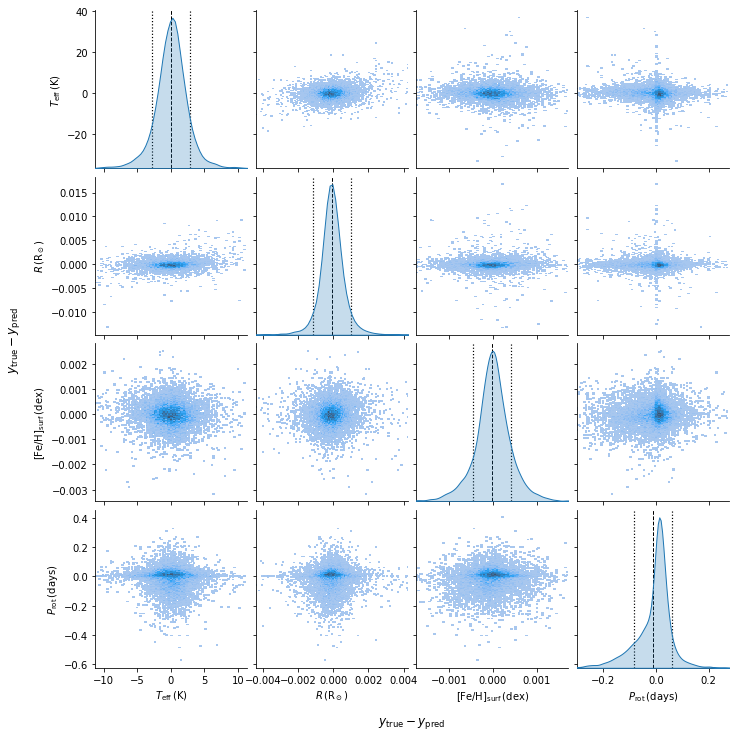

In [71]:
n_sample = 10000
scale = 4

grid = sns.pairplot(error.rename(columns=plot_cols).sample(n_sample), 
                    kind='hist', diag_kind='kde', vars=plot_cols.values());

# grid.map_lower(sns.kdeplot)

for i in range(len(plot_cols)):
    grid.axes[i, i].set_xlim(mean[i] - scale*std[i], mean[i] + scale*std[i])
    grid.axes[i, i].axvline(mean[i], c='k', ls='--', lw=1.)
    grid.axes[i, i].axvline(mean[i] - std[i], c='k', ls=':', lw=1.2)
    grid.axes[i, i].axvline(mean[i] + std[i], c='k', ls=':', lw=1.2)

ax = grid.fig.add_subplot(111, frame_on=False)
ax.tick_params(labelcolor="none", bottom=False, left=False)
ax.set_xlabel(r'$y_\mathrm{true} - y_\mathrm{pred}$', labelpad=30, fontdict={'size': 'large'})
ax.set_ylabel(r'$y_\mathrm{true} - y_\mathrm{pred}$', labelpad=50, fontdict={'size': 'large'})
# grid.fig.suptitle('Neural Network Test Error', y=1.02);

grid.fig.savefig(f'figures/{model_name}_error.png', dpi=150, bbox_inches='tight')
grid.fig.savefig(f'figures/{model_name}_error.pdf', dpi=150, bbox_inches='tight')

In [56]:
random_index = test.sample(50000).index

Text(0, 0.5, '$P_\\mathrm{rot,true} - P_\\mathrm{rot,pred}$')

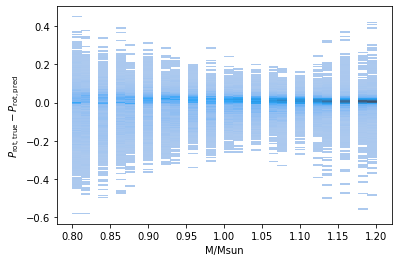

In [57]:
ax = sns.histplot(x=test.loc[random_index, 'M/Msun'], y=error.loc[random_index, '10^log(Prot)(days)'])

ax.set_ylabel(r'$P_\mathrm{rot,true} - P_\mathrm{rot,pred}$')

Text(0, 0.5, '$P_\\mathrm{rot,true} - P_\\mathrm{rot,pred}$')

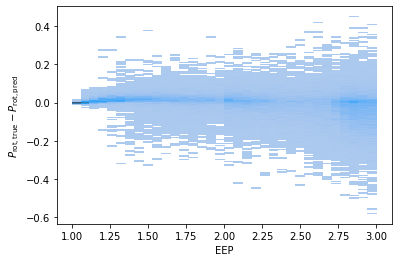

In [58]:
ax = sns.histplot(x=test.loc[random_index, 'EEP'], y=error.loc[random_index, '10^log(Prot)(days)'])

ax.set_ylabel(r'$P_\mathrm{rot,true} - P_\mathrm{rot,pred}$')

Text(0, 0.5, '$P_\\mathrm{rot,true} - P_\\mathrm{rot,pred}$')

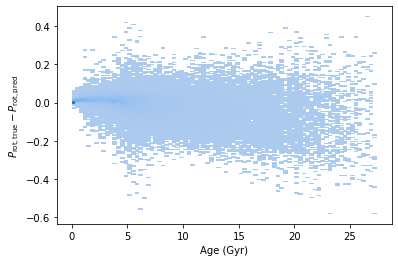

In [59]:
ax = sns.histplot(x=10**test.loc[random_index, 'log(Age)(Gyr)'], y=error.loc[random_index, '10^log(Prot)(days)'])

ax.set_xlabel('Age (Gyr)')
ax.set_ylabel(r'$P_\mathrm{rot,true} - P_\mathrm{rot,pred}$')

In [44]:
10**1.

10.0